# Recap

This week we do everything on MNIST due to time constraints
https://en.wikipedia.org/wiki/MNIST_database#/media/File:MnistExamples.png

In [0]:
classes=["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

In [0]:
import torchvision.transforms as transforms


# define the transformations the images go through each time it is used for training
# includes augmentation AND normalization as described above
augmentation_train = transforms.Compose([
                                  # randomly perform a horizontal flip of the image
                                  transforms.RandomHorizontalFlip(),
                                  # rotate the image with a angle from 0 to 60 (chosen randomly)
                                  transforms.RandomRotation(degrees=60),
                                  # convert the image into a tensor so it can be processed by the GPU
                                  transforms.ToTensor(),
                                  # normalize the image with the mean and std of ImageNet
                                   ])


# no augmentation for the test data only resizing, conversion to tensor and normalization
augmentation_test = transforms.Compose([
                    transforms.ToTensor(),
                    ])

In [0]:
import torchvision
toy_dataset_train = torchvision.datasets.MNIST(".", train=True, transform=augmentation_train, download=True)
toy_dataset_val = torchvision.datasets.MNIST(".", train=False, transform=augmentation_test, download=True)




In [5]:
print(len(toy_dataset_train))
from tqdm import tnrange, tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline

60000


In [7]:
# Declare the network
import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on:",device)
num_classes=10

class OurNet(nn.Module):
    def __init__(self):
        super(OurNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, (5,5), padding=2)
        self.conv2 = nn.Conv2d(6, 16, (3,3)) 
        self.fc1   = nn.Linear(16*13*13, 120)
        self.fc2   = nn.Linear(120, num_classes)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features



Running on: cuda


In [8]:
net = OurNet()
net = net.to(device)
summary(net, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
            Conv2d-2           [-1, 16, 26, 26]             880
            Linear-3                  [-1, 120]         324,600
            Linear-4                   [-1, 10]           1,210
Total params: 326,846
Trainable params: 326,846
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 1.25
Estimated Total Size (MB): 1.37
----------------------------------------------------------------


In [12]:
# Median Frequency Balancing

import numpy as np

# get the class labels of each image
class_labels = toy_dataset_train.targets
# empty array for counting instance of each class
count_labels = np.zeros(len(classes))
# empty array for weights of each class
class_weights = np.zeros(len(classes))

# populate the count array
for l in class_labels:
  count_labels[l] += 1

# get median count
median_freq = np.median(count_labels)
#print(median_freq)
#print(count_labels)

# calculate the weigths
for i in range(len(classes)):
  class_weights[i] = median_freq/count_labels[i]

# print the weights
for i in range(len(classes)):
    print(classes[i],":", class_weights[i])

0 : 1.0021948336991389
1 : 0.8804509047760308
2 : 0.9963074857334676
3 : 0.9681944217908988
4 : 1.016090380006847
5 : 1.0950009223390518
6 : 1.0030415680973301
7 : 0.9474860335195531
8 : 1.0145274312083405
9 : 0.9978147587829888


Now we define the loss function with the weights

In [0]:
class_weights = torch.FloatTensor(class_weights).to(device)

# loss function
criterion = nn.CrossEntropyLoss(weight = class_weights)

# Evaluation functions

Here we write a function which calculates the accuracy of model based on the validation dataset.

In [0]:
from sklearn.metrics import accuracy_score

def get_num_correct(predicted, labels):
    '''
    This function is used to decide if the predicted and ground truth classes are same or not.
    args: 
    predicted = output of model
    labels = true output
    '''
    batch_len, correct= 0, 0
    batch_len = labels.size(0)
    correct = (predicted == labels).sum().item()
    # correct = [1,1,1,1,2,3,4,5] predicted = [1,2,1,1,,2,3,4,6]
    return batch_len, correct

def evaluate(model, val_loader):
    '''
    This function calculates the total accuracy of the model on the validation set.
    args:
    model = the network we want to evaluate
    val_loader = the validation data loader
    '''
    losses= 0
    num_samples_total=0
    correct_total=0
    model.eval()
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        out = model(inputs)
        _, predicted = torch.max(out, 1)
        loss = criterion(out, labels)
        losses += loss.item() 
        b_len, corr = get_num_correct(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
    accuracy = correct_total/num_samples_total
    losses = losses/len(val_loader)
    return losses, accuracy

# Training Loop

In [15]:

def weight_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight.data)
net.apply(weight_init)

OurNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2704, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)

In [16]:
# define the batch size for training, val and testing
batch_size, validation_batch_size = 4096, 4096

import datetime
start_time = datetime.datetime.now()
import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr=1e-2)

num_w = 0
# create and instance of a dataloader for training
train_data_loader = torch.utils.data.DataLoader(toy_dataset_train, batch_size=batch_size, shuffle=True,num_workers=num_w)
validation_data_loader = torch.utils.data.DataLoader(toy_dataset_val, batch_size=validation_batch_size, shuffle=True,  num_workers=num_w)
# number of loops over the dataset

num_epochs = 5
accuracy = []
val_accuracy = []
losses = []
val_losses = []

print("Started Training")
epoch = 0
running_loss = 0.0
correct_total= 0.0
num_samples_total=0.0
train_accuracy = 0.0
val_acc=0.0
val_loss = 0.0
print('Epoch: %d' %(epoch+1))
print('Train Loss: %.3f  Train Accuracy:%.3f' %(running_loss, train_accuracy))
print('Validation Loss: %.3f  Val Accuracy: %.3f' %(val_loss, val_acc))

for epoch in tnrange(num_epochs):
    running_loss = 0.0
    correct_total= 0.0
    num_samples_total=0.0
    
    print("...")
    for i, data in tqdm_notebook(enumerate(train_data_loader)):
        if i % 2 == 0:
            print(f"Iteration: {i+1}/{len(train_data_loader)}")
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # set the parameter gradients to zero
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #compute accuracy
        _, predicted = torch.max(outputs, 1)
        b_len, corr = get_num_correct(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
        running_loss += loss.item()

    
    running_loss /= len(train_data_loader)
    train_accuracy = correct_total/num_samples_total
    val_loss, val_acc = evaluate(net, validation_data_loader)
    
    print('Epoch: %d' %(epoch+1))
    print('Train Loss: %.3f  Train Accuracy:%.3f' %(running_loss, train_accuracy))
    print('Validation Loss: %.3f  Val Accuracy: %.3f' %(val_loss, val_acc))

    losses.append(running_loss)
    val_losses.append(val_loss)
    accuracy.append(train_accuracy)
    val_accuracy.append(val_acc)
print('Finished Training')
end_time = datetime.datetime.now()
delta = end_time -start_time
print("Time for training of {} Epochs is {}s".format(num_epochs,delta.seconds))

Started Training
Epoch: 1
Train Loss: 0.000  Train Accuracy:0.000
Validation Loss: 0.000  Val Accuracy: 0.000


...


Iteration: 1/15
Iteration: 3/15
Iteration: 5/15
Iteration: 7/15
Iteration: 9/15
Iteration: 11/15
Iteration: 13/15
Iteration: 15/15
Epoch: 1
Train Loss: 1.759  Train Accuracy:0.388
Validation Loss: 0.983  Val Accuracy: 0.696
...


Iteration: 1/15
Iteration: 3/15
Iteration: 5/15
Iteration: 7/15
Iteration: 9/15
Iteration: 11/15
Iteration: 13/15
Iteration: 15/15
Epoch: 2
Train Loss: 0.956  Train Accuracy:0.694
Validation Loss: 0.629  Val Accuracy: 0.796
...


Iteration: 1/15
Iteration: 3/15
Iteration: 5/15
Iteration: 7/15
Iteration: 9/15
Iteration: 11/15
Iteration: 13/15
Iteration: 15/15
Epoch: 3
Train Loss: 0.647  Train Accuracy:0.796
Validation Loss: 0.388  Val Accuracy: 0.876
...


Iteration: 1/15
Iteration: 3/15
Iteration: 5/15
Iteration: 7/15
Iteration: 9/15
Iteration: 11/15
Iteration: 13/15
Iteration: 15/15
Epoch: 4
Train Loss: 0.459  Train Accuracy:0.854
Validation Loss: 0.318  Val Accuracy: 0.893
...


Iteration: 1/15
Iteration: 3/15
Iteration: 5/15
Iteration: 7/15
Iteration: 9/15
Iteration: 11/15
Iteration: 13/15
Iteration: 15/15
Epoch: 5
Train Loss: 0.344  Train Accuracy:0.892
Validation Loss: 0.248  Val Accuracy: 0.918

Finished Training
Time for training of 5 Epochs is 73s


# Train and Validation Curves

To better understand whether our network is actually learning something, we plot the training and validation curves.

There are two types of curves:
- Loss Curves: Plotting the trend of the loss per epoch.
- Accuracy Curves: Plotting accuracy, that is the performance of our model per epoch.

5


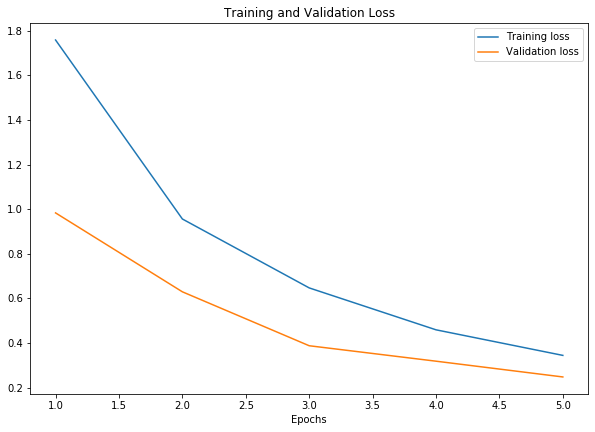

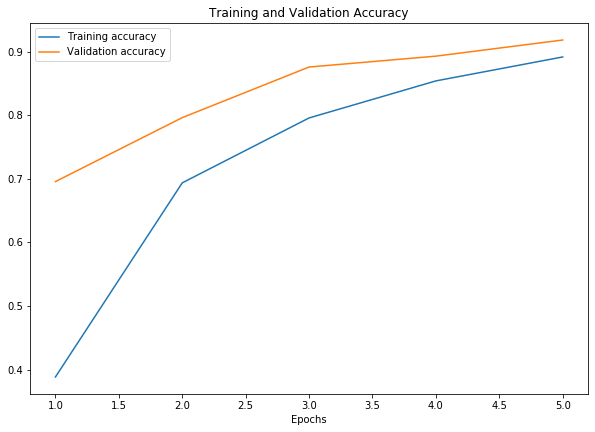

In [17]:
from tqdm import tnrange, tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline 
num_epochs=5
print(num_epochs)
epoch = range(1, num_epochs+1)
fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, losses, label='Training loss')
plt.plot(epoch, val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.legend()
#plt.figure()
plt.show()

fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, accuracy, label='Training accuracy')
plt.plot(epoch, val_accuracy, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
#plt.figure()
plt.show()

### fix los scala


# Common Training Errors

Let us look at some errors and how to detect them.



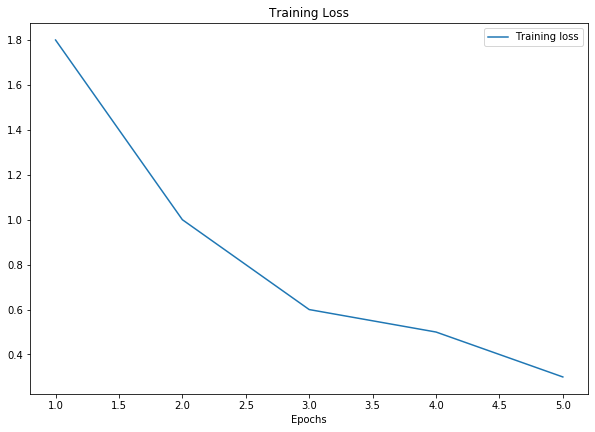

<Figure size 432x288 with 0 Axes>

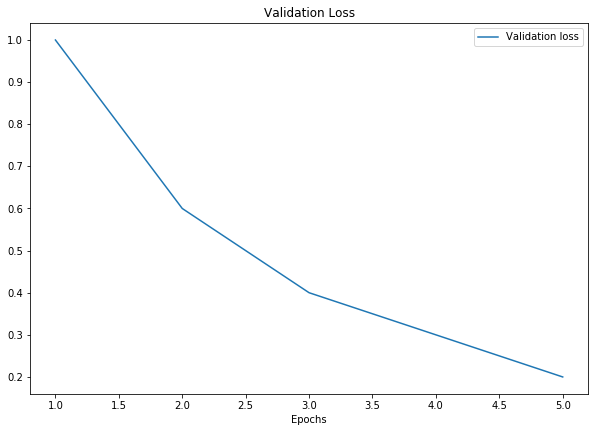

<Figure size 432x288 with 0 Axes>

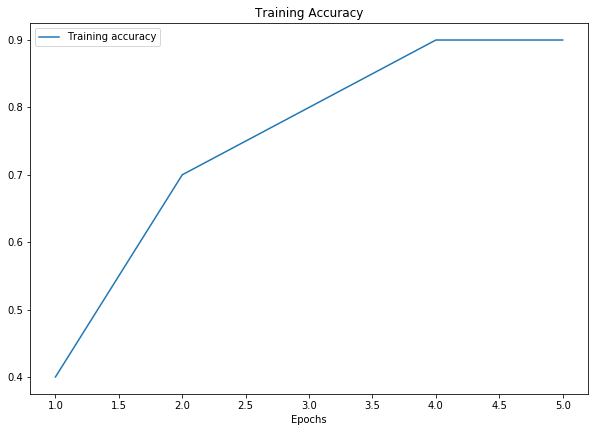

<Figure size 432x288 with 0 Axes>

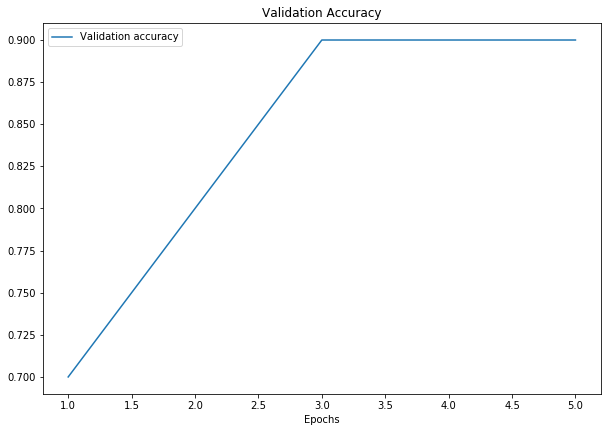

<Figure size 432x288 with 0 Axes>

In [18]:
# Rounding of the losses and accuracies to 2 decimal places.
from tqdm import tnrange, tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline 
n = 1 # round 2 places
losses = [round(x,n) for x in losses]
val_losses = [round(x,n) for x in val_losses]
accuracy = [round(x,n) for x in accuracy]
val_accuracy = [round(x,n) for x in val_accuracy]

epoch = range(1, num_epochs+1)
fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, losses, label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, val_losses, label='Validation loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()


fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, accuracy, label='Training accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, val_accuracy, label='Validation accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

## Data Scarcity

We need enough data to learn a good model. Less data means less learning.

Let's see how the performance is affected when we have less data.


In [19]:
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on:",device)
class OurNetBig(nn.Module):
    def __init__(self):
        super(OurNetBig, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, (5,5), padding=2)
        self.conv2 = nn.Conv2d(6, 16, (3,3), padding=2)
        self.conv3 = nn.Conv2d(16, 32, (3,3)) 
        self.fc1   = nn.Linear(32*13*13, 1000)
        self.fc2   = nn.Linear(1000, 120)
        self.fc3   = nn.Linear(120, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.relu(self.conv3(x))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
net_data = OurNetBig()
net_data = net_data.to(device)
summary(net_data, input_size=(1,28,28))

Running on: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
            Conv2d-2           [-1, 16, 30, 30]             880
            Conv2d-3           [-1, 32, 13, 13]           4,640
            Linear-4                 [-1, 1000]       5,409,000
            Linear-5                  [-1, 120]         120,120
            Linear-6                   [-1, 10]           1,210
Total params: 5,536,006
Trainable params: 5,536,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.20
Params size (MB): 21.12
Estimated Total Size (MB): 21.32
----------------------------------------------------------------


In [20]:
# we use the test data for training instead.
from torch.utils.data import Subset
batch_size = 50
subset_size = 200

length_dataset = [i for i in range(subset_size)]
small_toy_dataset_train = Subset(toy_dataset_train,length_dataset)
train_data_loader_small = torch.utils.data.DataLoader(small_toy_dataset_train, batch_size=batch_size, shuffle=True,num_workers=4)
validation_data_loader = torch.utils.data.DataLoader(toy_dataset_val, batch_size=batch_size, shuffle=True,  num_workers=4)

print(f"small dataset size: {len(small_toy_dataset_train)} batch_size: {batch_size} number of batches in dataloader: {len(train_data_loader_small)} ")


small dataset size: 200 batch_size: 50 number of batches in dataloader: 4 


In [21]:
def weight_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight.data)
net_data.apply(weight_init)

OurNetBig(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=5408, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)

In [22]:
# number of loops over the dataset
# optimizer
import torch.optim as optim 

num_epochs = 25
accuracy = []
val_accuracy = []
losses = []
val_losses = []
running_loss= 0.0
train_accuracy = 0.0
val_loss = 0.0
val_acc = 0.0
epoch=0

print('Epoch: %d' %(epoch+1))
print('Loss: %.3f  Accuracy:%.3f' %(running_loss, train_accuracy))
print('Validation Loss: %.3f  Val Accuracy: %.3f' %(val_loss, val_acc))

# intialize the network
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_data.parameters(), lr=1e-2)
print(net_data)
print("Started Training")

for epoch in tnrange(num_epochs):
    running_loss = 0.0
    correct_total= 0.0
    num_samples_total=0.0
    for i, data in tqdm_notebook(enumerate(train_data_loader_small)):
        #print(f"Iteration: {i+1}/{len(train_data_loader_small)}")
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # set the parameter gradients to zero
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_data(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #compute accuracy
        _, predicted = torch.max(outputs, 1)
        b_len, corr = get_num_correct(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
        running_loss += loss.item()

    
    running_loss /= len(train_data_loader_small)
    train_accuracy = correct_total/num_samples_total
    val_loss, val_acc = evaluate(net_data, validation_data_loader)
    
    print('Epoch: %d' %(epoch+1))
    print('Loss: %.3f  Accuracy:%.3f' %(running_loss, train_accuracy))
    print('Validation Loss: %.3f  Val Accuracy: %.3f' %(val_loss, val_acc))

    losses.append(running_loss)
    val_losses.append(val_loss)
    accuracy.append(train_accuracy)
    val_accuracy.append(val_acc)
print('Finished Training')

Epoch: 1
Loss: 0.000  Accuracy:0.000
Validation Loss: 0.000  Val Accuracy: 0.000
OurNetBig(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=5408, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)
Started Training


Epoch: 1
Loss: 3.006  Accuracy:0.105
Validation Loss: 2.313  Val Accuracy: 0.114


Epoch: 2
Loss: 2.293  Accuracy:0.130
Validation Loss: 2.301  Val Accuracy: 0.114


Epoch: 3
Loss: 2.303  Accuracy:0.130
Validation Loss: 2.296  Val Accuracy: 0.207


Epoch: 4
Loss: 2.256  Accuracy:0.225
Validation Loss: 2.336  Val Accuracy: 0.175


Epoch: 5
Loss: 2.165  Accuracy:0.235
Validation Loss: 2.195  Val Accuracy: 0.336


Epoch: 6
Loss: 2.000  Accuracy:0.320
Validation Loss: 1.866  Val Accuracy: 0.406


Epoch: 7
Loss: 1.696  Accuracy:0.400
Validation Loss: 1.631  Val Accuracy: 0.445


Epoch: 8
Loss: 1.692  Accuracy:0.460
Validation Loss: 1.550  Val Accuracy: 0.531


Epoch: 9
Loss: 1.333  Accuracy:0.580
Validation Loss: 1.282  Val Accuracy: 0.601


Epoch: 10
Loss: 1.343  Accuracy:0.530
Validation Loss: 1.310  Val Accuracy: 0.568


Epoch: 11
Loss: 1.165  Accuracy:0.620
Validation Loss: 1.254  Val Accuracy: 0.584


Epoch: 12
Loss: 0.930  Accuracy:0.680
Validation Loss: 1.235  Val Accuracy: 0.655


Epoch: 13
Loss: 0.815  Accuracy:0.750
Validation Loss: 1.286  Val Accuracy: 0.647


Epoch: 14
Loss: 0.976  Accuracy:0.640
Validation Loss: 1.050  Val Accuracy: 0.650


Epoch: 15
Loss: 0.842  Accuracy:0.705
Validation Loss: 1.063  Val Accuracy: 0.683


Epoch: 16
Loss: 0.757  Accuracy:0.770
Validation Loss: 1.127  Val Accuracy: 0.704


Epoch: 17
Loss: 0.686  Accuracy:0.785
Validation Loss: 0.979  Val Accuracy: 0.704


Epoch: 18
Loss: 0.642  Accuracy:0.755
Validation Loss: 0.971  Val Accuracy: 0.712


Epoch: 19
Loss: 0.596  Accuracy:0.805
Validation Loss: 0.994  Val Accuracy: 0.714


Epoch: 20
Loss: 0.556  Accuracy:0.795
Validation Loss: 1.061  Val Accuracy: 0.726


Epoch: 21
Loss: 0.530  Accuracy:0.850
Validation Loss: 1.019  Val Accuracy: 0.724


Epoch: 22
Loss: 0.567  Accuracy:0.785
Validation Loss: 0.980  Val Accuracy: 0.732


Epoch: 23
Loss: 0.442  Accuracy:0.850
Validation Loss: 1.168  Val Accuracy: 0.704


Epoch: 24
Loss: 0.450  Accuracy:0.860
Validation Loss: 1.036  Val Accuracy: 0.726


Epoch: 25
Loss: 0.354  Accuracy:0.855
Validation Loss: 1.048  Val Accuracy: 0.738

Finished Training


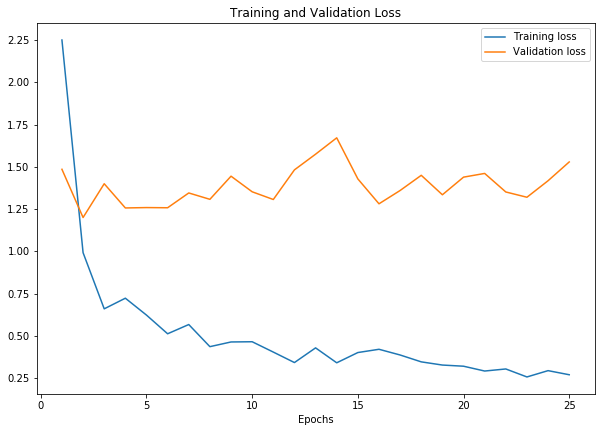

<Figure size 432x288 with 0 Axes>

In [0]:
epoch = range(1, num_epochs+1)
fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, losses, label='Training loss')
plt.plot(epoch, val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

#fig = plt.figure(figsize=(10, 15))
#plt.subplot(2,1,2)
#plt.plot(epoch, accuracy, label='Training accuracy')
#plt.plot(epoch, val_accuracy, label='Validation accuracy')
#plt.title('Training and Validation Accuracy')
#plt.xlabel('Epochs')
#plt.legend()
#plt.figure()
#plt.show()


## Learning Rate


In [0]:
net_lr = OurNet()
net_lr = net_lr.to(device)

# optimizer
import torch.optim as optim

optimizer_lr = optim.Adam(net_lr.parameters(), lr=10)

In [0]:
# number of loops over the dataset
num_epochs = 5
accuracy = []
val_accuracy = []
losses = []
val_losses = []

for epoch in tnrange(num_epochs):
    running_loss = 0.0
    correct_total= 0.0
    num_samples_total=0.0
    for i, data in tqdm_notebook(enumerate(train_data_loader)):
        print(f"Iteration: {i+1}/{len(train_data_loader)}")
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # set the parameter gradients to zero
        optimizer_lr.zero_grad()

        # forward + backward + optimize
        outputs = net_lr(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_lr.step()
        
        #compute accuracy
        _, predicted = torch.max(outputs, 1)
        b_len, corr = get_num_correct(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
        running_loss += loss.item()

    
    running_loss /= len(train_data_loader)
    train_accuracy = correct_total/num_samples_total
    val_loss, val_acc = evaluate(net_lr, validation_data_loader)
    
    print('Epoch: %d' %(epoch+1))
    print('Loss: %.3f  Accuracy:%.3f' %(running_loss, train_accuracy))
    print('Validation Loss: %.3f  Val Accuracy: %.3f' %(val_loss, val_acc))

    losses.append(running_loss)
    val_losses.append(val_loss)
    accuracy.append(train_accuracy)
    val_accuracy.append(val_acc)
print('Finished Training')

Iteration: 1/15
Iteration: 2/15
Iteration: 3/15
Iteration: 4/15
Iteration: 5/15
Iteration: 6/15
Iteration: 7/15
Iteration: 8/15
Iteration: 9/15
Iteration: 10/15
Iteration: 11/15
Iteration: 12/15
Iteration: 13/15
Iteration: 14/15
Iteration: 15/15

Epoch: 1
Loss: 897257625.092  Accuracy:0.100
Validation Loss: 56.091  Val Accuracy: 0.101


Iteration: 1/15
Iteration: 2/15
Iteration: 3/15
Iteration: 4/15
Iteration: 5/15
Iteration: 6/15
Iteration: 7/15
Iteration: 8/15
Iteration: 9/15
Iteration: 10/15
Iteration: 11/15
Iteration: 12/15
Iteration: 13/15
Iteration: 14/15
Iteration: 15/15

Epoch: 2
Loss: 29.148  Accuracy:0.103
Validation Loss: 14.726  Val Accuracy: 0.097


Iteration: 1/15
Iteration: 2/15
Iteration: 3/15
Iteration: 4/15
Iteration: 5/15
Iteration: 6/15
Iteration: 7/15
Iteration: 8/15
Iteration: 9/15
Iteration: 10/15
Iteration: 11/15
Iteration: 12/15
Iteration: 13/15
Iteration: 14/15
Iteration: 15/15

Epoch: 3
Loss: 11.288  Accuracy:0.099
Validation Loss: 8.048  Val Accuracy: 0.096


Iteration: 1/15
Iteration: 2/15
Iteration: 3/15
Iteration: 4/15
Iteration: 5/15
Iteration: 6/15
Iteration: 7/15
Iteration: 8/15
Iteration: 9/15
Iteration: 10/15
Iteration: 11/15
Iteration: 12/15
Iteration: 13/15
Iteration: 14/15
Iteration: 15/15

Epoch: 4
Loss: 4.722  Accuracy:0.100
Validation Loss: 3.333  Val Accuracy: 0.114


Iteration: 1/15
Iteration: 2/15
Iteration: 3/15
Iteration: 4/15
Iteration: 5/15
Iteration: 6/15
Iteration: 7/15
Iteration: 8/15
Iteration: 9/15
Iteration: 10/15
Iteration: 11/15
Iteration: 12/15
Iteration: 13/15
Iteration: 14/15
Iteration: 15/15

Epoch: 5
Loss: 2.923  Accuracy:0.098
Validation Loss: 2.610  Val Accuracy: 0.103

Finished Training


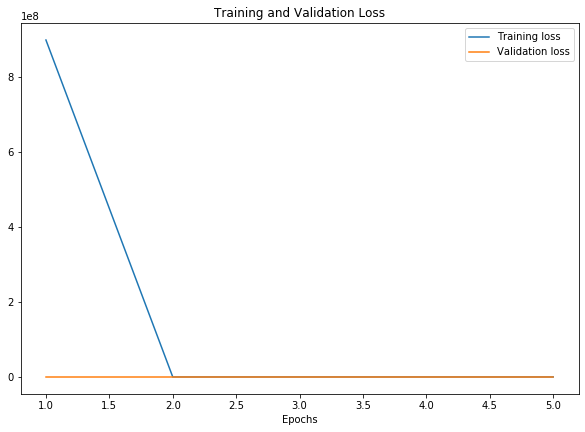

<Figure size 432x288 with 0 Axes>

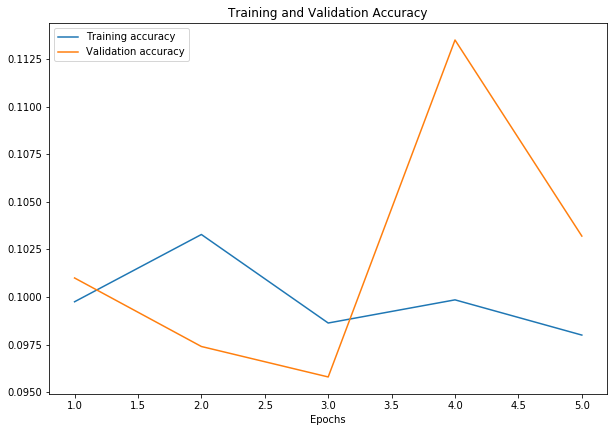

<Figure size 432x288 with 0 Axes>

In [0]:
epoch = range(1, num_epochs+1)
fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, losses, label='Training loss')
plt.plot(epoch, val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, accuracy, label='Training accuracy')
plt.plot(epoch, val_accuracy, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()


# Homework - Train a model which achieves 80% accuracy on HAM10000